# Import Relevant Libaries

## Install relevant versions

In [1]:
!pip install monai==1.4.0
!pip install pandas==2.0.3
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from monai.networks.schedulers import DDPMScheduler
from monai.inferers.inferer import DiffusionInferer
from torch.optim.lr_scheduler import MultiStepLR
import pandas as pd
from monai.bundle import ConfigParser
import nibabel as nib
from torch.utils.data import Dataset

#%% Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


# Setup Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Setup paths to uploaded training data
training_dataset = 'TrainingData_Key/slices_40_anon'

In [18]:
# Setup paths to uploaded config files
config_path_ = 'Configs/configs'

In [19]:
pretrained_path = 'trained_vAE_epoch_148.pt'

# Dataset Function

## Function to create datasets

In [20]:
def create_datasets(df, data_dir):

    df['Linked_Files_Anon'] = df['Linked_Files_Anon'].apply(lambda x: os.path.join(data_dir, x))

    train_data = df[df['Set']=='Train']
    valid_data = df[df['Set']=='Validation']
    test_data = df[df['Set']=='Test']

    train_data = train_data.reset_index()
    valid_data = valid_data.reset_index()
    test_data = test_data.reset_index()

    train_dataset = FDG_Dataset(data=train_data)
    valid_dataset = FDG_Dataset(data=valid_data)
    test_dataset = FDG_Dataset(data=test_data)

    return train_dataset, valid_dataset, test_dataset

## Dataset function

In [21]:
class FDG_Dataset(Dataset):
    """
    A PyTorch Dataset to load NIfTI files from a provided list of file paths.
    """
    def __init__(self, data):
        """
        Args:
            file_paths (list of Path objects): List of paths to the NIfTI files.
        """

        self.csv = data

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        diag = self.csv.loc[idx, 'DX_encoded']
        diag = torch.tensor(diag)
        file_name = self.csv.loc[idx, 'Linked_Files_Anon']

        nii_img  = nib.load(file_name)
        nii_data = nii_img.get_fdata()

        nii_data_scaled = (nii_data - nii_data.min())/(nii_data.max() - nii_data.min())
        image_tensor = torch.from_numpy(nii_data_scaled)

        return image_tensor, diag


# Load Pre-trained VAE

In [22]:
# Config filename
config_file="train_autoencoder.json"

# Weights Filename
weights_file="trained_vAE_epoch_148.pt"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Setup weights filepath
weights_path = os.path.join(pretrained_path, weights_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
vAE_model = config.get_parsed_content("gnetwork")

# Load checkpoint
checkpoint = torch.load(weights_path, map_location=device)

# Key remapping
key_mapping = {
    "encoder.blocks.10.to_q.weight": "encoder.blocks.10.attn.to_q.weight",
    "encoder.blocks.10.to_q.bias": "encoder.blocks.10.attn.to_q.bias",
    "encoder.blocks.10.to_k.weight": "encoder.blocks.10.attn.to_k.weight",
    "encoder.blocks.10.to_k.bias": "encoder.blocks.10.attn.to_k.bias",
    "encoder.blocks.10.to_v.weight": "encoder.blocks.10.attn.to_v.weight",
    "encoder.blocks.10.to_v.bias": "encoder.blocks.10.attn.to_v.bias",
    "encoder.blocks.10.proj_attn.weight": "encoder.blocks.10.attn.out_proj.weight",
    "encoder.blocks.10.proj_attn.bias": "encoder.blocks.10.attn.out_proj.bias",
    "decoder.blocks.2.to_q.weight": "decoder.blocks.2.attn.to_q.weight",
    "decoder.blocks.2.to_q.bias": "decoder.blocks.2.attn.to_q.bias",
    "decoder.blocks.2.to_k.weight": "decoder.blocks.2.attn.to_k.weight",
    "decoder.blocks.2.to_k.bias": "decoder.blocks.2.attn.to_k.bias",
    "decoder.blocks.2.to_v.weight": "decoder.blocks.2.attn.to_v.weight",
    "decoder.blocks.2.to_v.bias": "decoder.blocks.2.attn.to_v.bias",
    "decoder.blocks.2.proj_attn.weight": "decoder.blocks.2.attn.out_proj.weight",
    "decoder.blocks.2.proj_attn.bias": "decoder.blocks.2.attn.out_proj.bias",
    "decoder.blocks.6.conv.conv.weight": "decoder.blocks.6.postconv.conv.weight",
    "decoder.blocks.6.conv.conv.bias": "decoder.blocks.6.postconv.conv.bias",
    "decoder.blocks.9.conv.conv.weight": "decoder.blocks.9.postconv.conv.weight",
    "decoder.blocks.9.conv.conv.bias": "decoder.blocks.9.postconv.conv.bias",
}

# Remap keys
new_state_dict = {key_mapping.get(k, k): v for k, v in checkpoint.items()}

# Load state
vAE_model.load_state_dict(new_state_dict, strict=False)
vAE_model.to(device)


AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x AEKLResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): AEKLDownsample(
        (pad): AsymmetricPad()
        (conv): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4): AEKLResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
  

#Create LDM

In [23]:
# Load config file
config_file="train_cond_diffusion.json"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
LDM_model = config.get_parsed_content("diffusion")

#Setup parameters of LDM

In [24]:
import math

class CombinedScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup_epochs, training_epochs, cooldown_epochs, init_lr, fin_lr, last_epoch=-1):

        self.warmup_epochs = warmup_epochs

        self.training_epochs = training_epochs

        self.cooldown_epochs = cooldown_epochs

        self.init_lr = init_lr

        self.fin_lr = fin_lr

        super().__init__(optimizer, last_epoch=last_epoch)

    def get_lr(self):

        epoch = self.last_epoch

        # Warmup phase: linearly increase from 1e-8 to init_lr

        if epoch < self.warmup_epochs:

            progress = epoch / self.warmup_epochs

            return [1e-8 + (self.init_lr - 1e-8) * progress for _ in self.base_lrs]

        # Training phase: cosine decay from init_lr to fin_lr

        elif epoch < self.warmup_epochs + self.training_epochs:

            progress = (epoch - self.warmup_epochs) / self.training_epochs

            cosine_decay = 0.5 * (1 + math.cos(progress * math.pi))

            return [self.fin_lr + (self.init_lr - self.fin_lr) * cosine_decay for _ in self.base_lrs]

        # Cooldown phase: linearly decrease from fin_lr to 1e-8

        elif epoch < self.warmup_epochs + self.training_epochs + self.cooldown_epochs:

            progress = (epoch - self.warmup_epochs - self.training_epochs) / self.cooldown_epochs

            return [self.fin_lr + (1e-8 - self.fin_lr) * progress for _ in self.base_lrs]

        # Beyond all phases: hold at the minimum lr (1e-8)

        else:

            return [1e-8 for _ in self.base_lrs]


In [25]:
# Datasets / Dataloader
data = os.path.join('TrainingData_Key/data_key_anon.csv')
data = pd.read_csv(data)
train_dataset, valid_dataset, test_dataset = create_datasets(data, training_dataset)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

# Epochs
training_epochs = 500

# Learning rate
init_lr = 5e-05
fin_lr = 1e-08
# Optimizer
optimiser = optim.Adam(LDM_model.parameters(), lr=init_lr)
# Learning rate scheduler
#lr_scheduler = CombinedScheduler(optimiser, 1, training_epochs, 20, init_lr, fin_lr)

# LDM Scheduler
ldm_scheduler = DDPMScheduler(schedule="scaled_linear_beta", num_train_timesteps=1000, beta_start=0.0015, beta_end= 0.0195)

# Inferer
inferer = DiffusionInferer(ldm_scheduler)

# Output folder
output_folder = '/content/output'

# Code to train conditional LDM

/tmp/ipykernel_1497842/3192518168.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1497842/3192518168.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 0: 100%|█| 16/16 [00:11<00:00,  1.45it/s, loss=tensor(0.9516, de
/tmp/ipykernel_1497842/3192518168.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipykernel_1497842/3192518168.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 0, Training Loss: 7.79178911447525, Validation Loss: 0.9435189664363861


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.37it/s]


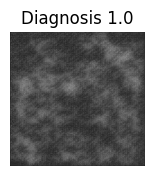

Epoch 1: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.8740, de


Epoch 1, Training Loss: 7.31707176566124, Validation Loss: 0.8775885999202728


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.36it/s]


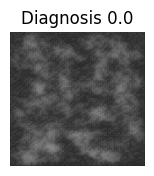

Epoch 2: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.8024, de


Epoch 2, Training Loss: 6.773859649896622, Validation Loss: 0.8162178993225098


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.44it/s]


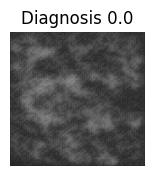

Epoch 3: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.7452, de


Epoch 3, Training Loss: 6.189709931612015, Validation Loss: 0.7359184324741364


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 35.77it/s]


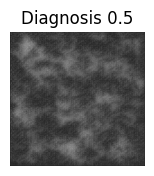

Epoch 4: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.6630, de


Epoch 4, Training Loss: 5.622833460569382, Validation Loss: 0.6544782221317291


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.83it/s]


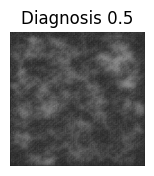

Epoch 5: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.5812, de


Epoch 5, Training Loss: 5.047958314418793, Validation Loss: 0.5862341821193695


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.96it/s]


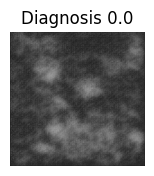

Epoch 6: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.5372, de


Epoch 6, Training Loss: 4.4975385665893555, Validation Loss: 0.5281317234039307


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.83it/s]


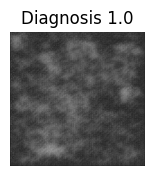

Epoch 7: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.4602, de


Epoch 7, Training Loss: 3.9163393676280975, Validation Loss: 0.4555194079875946


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.90it/s]


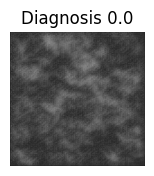

Epoch 8: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.3965, de


Epoch 8, Training Loss: 3.4925383180379868, Validation Loss: 0.4191891700029373


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.67it/s]


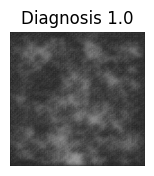

Epoch 9: 100%|█| 16/16 [00:10<00:00,  1.58it/s, loss=tensor(0.3607, de


Epoch 9, Training Loss: 3.0737691670656204, Validation Loss: 0.37428922951221466


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.58it/s]


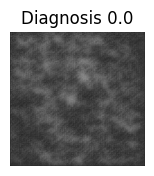

Epoch 10: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.2989, d


Epoch 10, Training Loss: 2.6775870323181152, Validation Loss: 0.30589669942855835


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.89it/s]


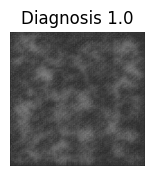

Epoch 11: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.2862, d


Epoch 11, Training Loss: 2.423922508955002, Validation Loss: 0.2691267430782318


IOPub message rate exceeded.█████▏                                                   | 352/1000 [00:09<00:17, 37.17it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 163: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0021, 


Epoch 163, Training Loss: 0.020276478782761842, Validation Loss: 0.0022469551768153906


Epoch 164: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0018, 


Epoch 164, Training Loss: 0.016951475176028907, Validation Loss: 0.002693910850211978


Epoch 165: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 165, Training Loss: 0.017645336862187833, Validation Loss: 0.002078189398162067


Epoch 166: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0021, 


Epoch 166, Training Loss: 0.01829971600091085, Validation Loss: 0.0019577297498472035


Epoch 167: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0024, 


Epoch 167, Training Loss: 0.0207128293113783, Validation Loss: 0.002146272687241435


Epoch 168: 100%|█| 16/16 [00:09<00:00,  1.63it/s, loss=tensor(0.0027, 


Epoch 168, Training Loss: 0.019376223674044013, Validation Loss: 0.0019864211790263653


Epoch 169: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0034, 


Epoch 169, Training Loss: 0.02697579556843266, Validation Loss: 0.00238569313660264


Epoch 170: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0017, 


Epoch 170, Training Loss: 0.02535157452803105, Validation Loss: 0.002587866154499352


Epoch 171: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0151, 


Epoch 171, Training Loss: 0.035222752252593637, Validation Loss: 0.006565207149833441


Epoch 172: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0054, 


Epoch 172, Training Loss: 0.03664576087612659, Validation Loss: 0.004119811928831041


Epoch 173: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0029, 


Epoch 173, Training Loss: 0.02803769230376929, Validation Loss: 0.002947887987829745


Epoch 174: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0024, 


Epoch 174, Training Loss: 0.03018050134414807, Validation Loss: 0.004470358602702618


Epoch 175: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0022, 


Epoch 175, Training Loss: 0.02082203875761479, Validation Loss: 0.0024406769080087543


Epoch 176: 100%|█| 16/16 [00:09<00:00,  1.63it/s, loss=tensor(0.0023, 


Epoch 176, Training Loss: 0.01884152280399576, Validation Loss: 0.0019992091110907495


Epoch 177: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0023, 


Epoch 177, Training Loss: 0.01819391269236803, Validation Loss: 0.0020903029944747686


Epoch 178: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0017, 


Epoch 178, Training Loss: 0.015254275349434465, Validation Loss: 0.0020834754686802626


Epoch 179: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0020, 


Epoch 179, Training Loss: 0.015827306953724474, Validation Loss: 0.002565769711509347


Epoch 180: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0030, 


Epoch 180, Training Loss: 0.021348306443542242, Validation Loss: 0.002176078734919429


Epoch 181: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0025, 


Epoch 181, Training Loss: 0.022174621815793216, Validation Loss: 0.0038852671859785914


Epoch 182: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0059, 


Epoch 182, Training Loss: 0.0236818726407364, Validation Loss: 0.00288983469363302


Epoch 183: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0024, 


Epoch 183, Training Loss: 0.021339362836442888, Validation Loss: 0.00196628225967288


Epoch 184: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0048, 


Epoch 184, Training Loss: 0.0210321550257504, Validation Loss: 0.0021047379123046994


Epoch 185: 100%|█| 16/16 [00:10<00:00,  1.52it/s, loss=tensor(0.0026, 


Epoch 185, Training Loss: 0.023532478720881045, Validation Loss: 0.0038230076897889376


Epoch 186: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0030, 


Epoch 186, Training Loss: 0.03512655955273658, Validation Loss: 0.003707906580530107


Epoch 187: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0025, 


Epoch 187, Training Loss: 0.022919065319001675, Validation Loss: 0.002180845011025667


Epoch 188: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0081, 


Epoch 188, Training Loss: 0.031780472258105874, Validation Loss: 0.0028600041987374425


Epoch 189: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0030, 


Epoch 189, Training Loss: 0.03728305408731103, Validation Loss: 0.003507551969960332


Epoch 190: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0054, 


Epoch 190, Training Loss: 0.028260311693884432, Validation Loss: 0.0022314087254926562


Epoch 191: 100%|█| 16/16 [00:10<00:00,  1.50it/s, loss=tensor(0.0022, 


Epoch 191, Training Loss: 0.025205350248143077, Validation Loss: 0.0024160122266039252


Epoch 192: 100%|█| 16/16 [00:10<00:00,  1.56it/s, loss=tensor(0.0022, 


Epoch 192, Training Loss: 0.018592183536384255, Validation Loss: 0.001664469309616834


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.94it/s]


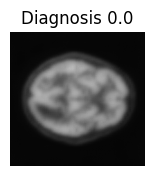

Epoch 193: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0017, 


Epoch 193, Training Loss: 0.016155892692040652, Validation Loss: 0.0018014339148066938


Epoch 194: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 194, Training Loss: 0.014557229180354625, Validation Loss: 0.0017502474365755916


Epoch 195: 100%|█| 16/16 [00:10<00:00,  1.50it/s, loss=tensor(0.0025, 


Epoch 195, Training Loss: 0.016241099394392222, Validation Loss: 0.002145371283404529


Epoch 196: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0057, 


Epoch 196, Training Loss: 0.020216963021084666, Validation Loss: 0.0027408062014728785


Epoch 197: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0020, 


Epoch 197, Training Loss: 0.023980745463632047, Validation Loss: 0.00199648184934631


Epoch 198: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0026, 


Epoch 198, Training Loss: 0.020183231798000634, Validation Loss: 0.0027443761937320232


Epoch 199: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 199, Training Loss: 0.018888281716499478, Validation Loss: 0.0020794382435269654


Epoch 200: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0015, 


Epoch 200, Training Loss: 0.016970225609838963, Validation Loss: 0.001578663068357855


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.96it/s]


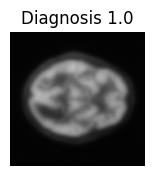

Epoch 201: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0040, 


Epoch 201, Training Loss: 0.022376184759195894, Validation Loss: 0.003555994830094278


Epoch 202: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0022, 


Epoch 202, Training Loss: 0.024361001269426197, Validation Loss: 0.004555023624561727


Epoch 203: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0023, 


Epoch 203, Training Loss: 0.02234224881976843, Validation Loss: 0.0031055795261636376


Epoch 204: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 204, Training Loss: 0.019391239096876234, Validation Loss: 0.0026184446178376675


Epoch 205: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0016, 


Epoch 205, Training Loss: 0.017864535795524716, Validation Loss: 0.0032069914741441607


Epoch 206: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0035, 


Epoch 206, Training Loss: 0.03377593320328742, Validation Loss: 0.0047819181345403194


Epoch 207: 100%|█| 16/16 [00:10<00:00,  1.50it/s, loss=tensor(0.0051, 


Epoch 207, Training Loss: 0.048029288300313056, Validation Loss: 0.009576755343005061


Epoch 208: 100%|█| 16/16 [00:10<00:00,  1.58it/s, loss=tensor(0.0027, 


Epoch 208, Training Loss: 0.05405293800868094, Validation Loss: 0.004763054428622127


Epoch 209: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0044, 


Epoch 209, Training Loss: 0.04563169367611408, Validation Loss: 0.002935430151410401


Epoch 210: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0031, 


Epoch 210, Training Loss: 0.032465530443005264, Validation Loss: 0.003934346139431


Epoch 211: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0027, 


Epoch 211, Training Loss: 0.03127198712900281, Validation Loss: 0.002680017496459186


Epoch 212: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0019, 


Epoch 212, Training Loss: 0.01835606386885047, Validation Loss: 0.0016866385703906417


Epoch 213: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0018, 


Epoch 213, Training Loss: 0.01564799342304468, Validation Loss: 0.0018155318684875965


Epoch 214: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0026, 


Epoch 214, Training Loss: 0.015574443328659981, Validation Loss: 0.002122752368450165


Epoch 215: 100%|█| 16/16 [00:10<00:00,  1.55it/s, loss=tensor(0.0015, 


Epoch 215, Training Loss: 0.015043571242131293, Validation Loss: 0.0019506756216287613


Epoch 216: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0015, 


Epoch 216, Training Loss: 0.013535756443161517, Validation Loss: 0.0014079570537433028


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.75it/s]


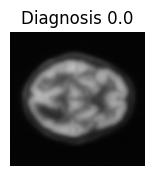

Epoch 217: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0021, 


Epoch 217, Training Loss: 0.015164264477789402, Validation Loss: 0.0022888322127982974


Epoch 218: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 218, Training Loss: 0.014942991081625223, Validation Loss: 0.0023139837430790067


Epoch 219: 100%|█| 16/16 [00:10<00:00,  1.51it/s, loss=tensor(0.0017, 


Epoch 219, Training Loss: 0.016846349753905088, Validation Loss: 0.002043035114184022


Epoch 220: 100%|█| 16/16 [00:10<00:00,  1.56it/s, loss=tensor(0.0016, 


Epoch 220, Training Loss: 0.014591217623092234, Validation Loss: 0.0017722270567901433


Epoch 221: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 221, Training Loss: 0.02035135414917022, Validation Loss: 0.0022767832269892097


Epoch 222: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0022, 


Epoch 222, Training Loss: 0.02227736689383164, Validation Loss: 0.002168228034861386


Epoch 223: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0017, 


Epoch 223, Training Loss: 0.019225806987378746, Validation Loss: 0.0019848322845064104


Epoch 224: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0040, 


Epoch 224, Training Loss: 0.04038301797118038, Validation Loss: 0.005420160014182329


Epoch 225: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0063, 


Epoch 225, Training Loss: 0.035035820794291794, Validation Loss: 0.0019995729671791196


Epoch 226: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0028, 


Epoch 226, Training Loss: 0.02370513044297695, Validation Loss: 0.0031069107353687286


Epoch 227: 100%|█| 16/16 [00:10<00:00,  1.56it/s, loss=tensor(0.0024, 


Epoch 227, Training Loss: 0.019856938160955906, Validation Loss: 0.0019258149550296366


Epoch 228: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0017, 


Epoch 228, Training Loss: 0.017540302826091647, Validation Loss: 0.0017585408641025424


Epoch 229: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 229, Training Loss: 0.014559978269971907, Validation Loss: 0.002363320381846279


Epoch 230: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0020, 


Epoch 230, Training Loss: 0.017487989680375904, Validation Loss: 0.004306394141167402


Epoch 231: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 231, Training Loss: 0.024414709478151053, Validation Loss: 0.0018531399546191096


Epoch 232: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 232, Training Loss: 0.01852756890002638, Validation Loss: 0.0019676831434480846


Epoch 233: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0016, 


Epoch 233, Training Loss: 0.014755345066078007, Validation Loss: 0.0021656081080436707


Epoch 234: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0016, 


Epoch 234, Training Loss: 0.01354728190926835, Validation Loss: 0.0015850367490202188


Epoch 235: 100%|█| 16/16 [00:09<00:00,  1.65it/s, loss=tensor(0.0018, 


Epoch 235, Training Loss: 0.012267235841136426, Validation Loss: 0.0019072865834459662


Epoch 236: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 236, Training Loss: 0.012986597954295576, Validation Loss: 0.0016697283717803657


Epoch 237: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0030, 


Epoch 237, Training Loss: 0.013214058824814856, Validation Loss: 0.0014251232496462762


Epoch 238: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0017, 


Epoch 238, Training Loss: 0.013998827838804573, Validation Loss: 0.0015206231037154794


Epoch 239: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0030, 


Epoch 239, Training Loss: 0.014868723112158477, Validation Loss: 0.0028775976388715208


Epoch 240: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0015, 


Epoch 240, Training Loss: 0.015270783915184438, Validation Loss: 0.0022729120100848377


Epoch 241: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0017, 


Epoch 241, Training Loss: 0.016060505295172334, Validation Loss: 0.004021336906589568


Epoch 242: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 242, Training Loss: 0.01543349213898182, Validation Loss: 0.002179178991355002


Epoch 243: 100%|█| 16/16 [00:09<00:00,  1.65it/s, loss=tensor(0.0016, 


Epoch 243, Training Loss: 0.01585165219148621, Validation Loss: 0.0027500580763444304


Epoch 244: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0024, 


Epoch 244, Training Loss: 0.017500580055639148, Validation Loss: 0.0020282031618990004


Epoch 245: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0045, 


Epoch 245, Training Loss: 0.03934471413958818, Validation Loss: 0.005413660313934088


Epoch 246: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0035, 


Epoch 246, Training Loss: 0.03415800235234201, Validation Loss: 0.003482016851194203


Epoch 247: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0028, 


Epoch 247, Training Loss: 0.024605382815934718, Validation Loss: 0.002384236198849976


Epoch 248: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0022, 


Epoch 248, Training Loss: 0.020783948013558984, Validation Loss: 0.003026051796041429


Epoch 249: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0021, 


Epoch 249, Training Loss: 0.022105084790382534, Validation Loss: 0.0024462469154968858


Epoch 250: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 250, Training Loss: 0.021641072118654847, Validation Loss: 0.0027742814272642136


Epoch 251: 100%|█| 16/16 [00:09<00:00,  1.65it/s, loss=tensor(0.0024, 


Epoch 251, Training Loss: 0.02119930402841419, Validation Loss: 0.0041158965323120356


Epoch 252: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0026, 


Epoch 252, Training Loss: 0.02653329132590443, Validation Loss: 0.0024869421031326056


Epoch 253: 100%|█| 16/16 [00:11<00:00,  1.45it/s, loss=tensor(0.0019, 


Epoch 253, Training Loss: 0.020695924176834524, Validation Loss: 0.0028352385852485895


Epoch 254: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0032, 


Epoch 254, Training Loss: 0.02513600594829768, Validation Loss: 0.004526573931798339


Epoch 255: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0046, 


Epoch 255, Training Loss: 0.03773341083433479, Validation Loss: 0.0032036518678069115


Epoch 256: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0037, 


Epoch 256, Training Loss: 0.03496840503066778, Validation Loss: 0.0022737993858754635


Epoch 257: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0015, 


Epoch 257, Training Loss: 0.025037401646841317, Validation Loss: 0.0018320640083402395


Epoch 258: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0030, 


Epoch 258, Training Loss: 0.01796154532348737, Validation Loss: 0.0014383457018993795


Epoch 259: 100%|█| 16/16 [00:09<00:00,  1.64it/s, loss=tensor(0.0022, 


Epoch 259, Training Loss: 0.015432232001330703, Validation Loss: 0.0020079162786714733


Epoch 260: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 260, Training Loss: 0.013548463000915945, Validation Loss: 0.002228192868642509


Epoch 261: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0014, 


Epoch 261, Training Loss: 0.014553969958797097, Validation Loss: 0.0022460840409621596


Epoch 262: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0016, 


Epoch 262, Training Loss: 0.014401336840819567, Validation Loss: 0.0017991104978136718


Epoch 263: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 263, Training Loss: 0.01232759322738275, Validation Loss: 0.0017868455033749342


Epoch 264: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0015, 


Epoch 264, Training Loss: 0.012735735159367323, Validation Loss: 0.0015421350835822523


Epoch 265: 100%|█| 16/16 [00:10<00:00,  1.51it/s, loss=tensor(0.0014, 


Epoch 265, Training Loss: 0.013436175242532045, Validation Loss: 0.0027373400516808033


Epoch 266: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0024, 


Epoch 266, Training Loss: 0.03292245912598446, Validation Loss: 0.0032973799388855696


Epoch 267: 100%|█| 16/16 [00:08<00:00,  1.87it/s, loss=tensor(0.0028, 


Epoch 267, Training Loss: 0.029786162660457194, Validation Loss: 0.0034965495578944683


Epoch 268: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0021, 


Epoch 268, Training Loss: 0.025835087231826037, Validation Loss: 0.005268601700663567


Epoch 269: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0013, 


Epoch 269, Training Loss: 0.019181179639417678, Validation Loss: 0.001657032873481512


Epoch 270: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 270, Training Loss: 0.01702333043795079, Validation Loss: 0.0019250425975769758


Epoch 271: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0014, 


Epoch 271, Training Loss: 0.015405509562697262, Validation Loss: 0.0016474807634949684


Epoch 272: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0015, 


Epoch 272, Training Loss: 0.013109290273860097, Validation Loss: 0.0018579707248136401


Epoch 273: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 273, Training Loss: 0.013938624586444348, Validation Loss: 0.00202361581614241


Epoch 274: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 274, Training Loss: 0.012524888676125556, Validation Loss: 0.0020023671095259488


Epoch 275: 100%|█| 16/16 [00:09<00:00,  1.64it/s, loss=tensor(0.0019, 


Epoch 275, Training Loss: 0.012364884954877198, Validation Loss: 0.001556490024086088


Epoch 276: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 276, Training Loss: 0.0106875347555615, Validation Loss: 0.001345024909824133


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.87it/s]


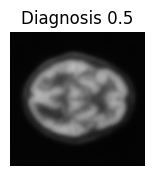

Epoch 277: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 277, Training Loss: 0.012986283167265356, Validation Loss: 0.0013108037528581917


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.48it/s]


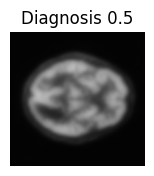

Epoch 278: 100%|█| 16/16 [00:10<00:00,  1.46it/s, loss=tensor(0.0048, 


Epoch 278, Training Loss: 0.015321690414566547, Validation Loss: 0.0016804374754428864


Epoch 279: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0018, 


Epoch 279, Training Loss: 0.016585030709393322, Validation Loss: 0.001939491310622543


Epoch 280: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0016, 


Epoch 280, Training Loss: 0.013668687082827091, Validation Loss: 0.0015748338773846626


Epoch 281: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 281, Training Loss: 0.012861946655903012, Validation Loss: 0.0013713484513573349


Epoch 282: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0020, 


Epoch 282, Training Loss: 0.013319919933564961, Validation Loss: 0.0012249895953573287


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.92it/s]


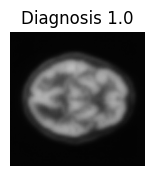

Epoch 283: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 283, Training Loss: 0.01259401609422639, Validation Loss: 0.0017139093251898885


Epoch 284: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 284, Training Loss: 0.011347516730893403, Validation Loss: 0.0014450224698521197


Epoch 285: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0027, 


Epoch 285, Training Loss: 0.01499488711124286, Validation Loss: 0.0014089473406784236


Epoch 286: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0013, 


Epoch 286, Training Loss: 0.012108453374821693, Validation Loss: 0.001842897618189454


Epoch 287: 100%|█| 16/16 [00:09<00:00,  1.65it/s, loss=tensor(0.0016, 


Epoch 287, Training Loss: 0.018429554882459342, Validation Loss: 0.003705536015331745


Epoch 288: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0028, 


Epoch 288, Training Loss: 0.016725574911106378, Validation Loss: 0.001549577049445361


Epoch 289: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 289, Training Loss: 0.012581108487211168, Validation Loss: 0.0016579347429797053


Epoch 290: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0016, 


Epoch 290, Training Loss: 0.01777533016866073, Validation Loss: 0.0016725542373023927


Epoch 291: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 291, Training Loss: 0.013846179761458188, Validation Loss: 0.001370436220895499


Epoch 292: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0013, 


Epoch 292, Training Loss: 0.011395631823688745, Validation Loss: 0.0016398443258367479


Epoch 293: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0047, 


Epoch 293, Training Loss: 0.015691024775151163, Validation Loss: 0.002990444074384868


Epoch 294: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0019, 


Epoch 294, Training Loss: 0.017694128211587667, Validation Loss: 0.0028776523540727794


Epoch 295: 100%|█| 16/16 [00:09<00:00,  1.70it/s, loss=tensor(0.0026, 


Epoch 295, Training Loss: 0.01814600359648466, Validation Loss: 0.001517670345492661


Epoch 296: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0021, 


Epoch 296, Training Loss: 0.012887675839010626, Validation Loss: 0.0014019939117133617


Epoch 297: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0027, 


Epoch 297, Training Loss: 0.015598892408888787, Validation Loss: 0.002349121612496674


Epoch 298: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0030, 


Epoch 298, Training Loss: 0.02068171405699104, Validation Loss: 0.0014851930900476873


Epoch 299: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 299, Training Loss: 0.016383180336561054, Validation Loss: 0.003410111297853291


Epoch 300: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0052, 


Epoch 300, Training Loss: 0.04794417112134397, Validation Loss: 0.004184788907878101


Epoch 301: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0039, 


Epoch 301, Training Loss: 0.027281038695946336, Validation Loss: 0.0022203410044312477


Epoch 302: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 302, Training Loss: 0.015207969234324992, Validation Loss: 0.0016369051882065833


Epoch 303: 100%|█| 16/16 [00:09<00:00,  1.63it/s, loss=tensor(0.0019, 


Epoch 303, Training Loss: 0.023834702209569514, Validation Loss: 0.002231937600299716


Epoch 304: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0019, 


Epoch 304, Training Loss: 0.02409430150873959, Validation Loss: 0.0029878801433369517


Epoch 305: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0018, 


Epoch 305, Training Loss: 0.01727753662271425, Validation Loss: 0.0032692315289750695


Epoch 306: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 306, Training Loss: 0.011829867435153574, Validation Loss: 0.001388334494549781


Epoch 307: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 307, Training Loss: 0.010904193622991443, Validation Loss: 0.001312517502810806


Epoch 308: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0016, 


Epoch 308, Training Loss: 0.011976630077697337, Validation Loss: 0.0017875367775559425


Epoch 309: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 309, Training Loss: 0.01278740749694407, Validation Loss: 0.0014589963247999549


Epoch 310: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0024, 


Epoch 310, Training Loss: 0.016717721184249967, Validation Loss: 0.0023877525236457586


Epoch 311: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0015, 


Epoch 311, Training Loss: 0.018759825557935983, Validation Loss: 0.0019020508043467999


Epoch 312: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0015, 


Epoch 312, Training Loss: 0.013641214929521084, Validation Loss: 0.0018424061709083617


Epoch 313: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 313, Training Loss: 0.011033930466510355, Validation Loss: 0.0013790674856863916


Epoch 314: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0017, 


Epoch 314, Training Loss: 0.010859776462893933, Validation Loss: 0.001641296490561217


Epoch 315: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 315, Training Loss: 0.017676012590527534, Validation Loss: 0.0051617169519886374


Epoch 316: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 316, Training Loss: 0.021894827077630907, Validation Loss: 0.002464074525050819


Epoch 317: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0021, 


Epoch 317, Training Loss: 0.020674553757999092, Validation Loss: 0.0018778963712975383


Epoch 318: 100%|█| 16/16 [00:10<00:00,  1.51it/s, loss=tensor(0.0020, 


Epoch 318, Training Loss: 0.015213914215564728, Validation Loss: 0.0013702240539714694


Epoch 319: 100%|█| 16/16 [00:10<00:00,  1.59it/s, loss=tensor(0.0010, 


Epoch 319, Training Loss: 0.011318815464619547, Validation Loss: 0.0013252751086838543


Epoch 320: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0009, 


Epoch 320, Training Loss: 0.009956274589058012, Validation Loss: 0.0010893018916249275


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.15it/s]


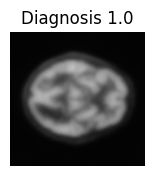

Epoch 321: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 321, Training Loss: 0.010501813958398998, Validation Loss: 0.0015816548839211464


Epoch 322: 100%|█| 16/16 [00:10<00:00,  1.51it/s, loss=tensor(0.0011, 


Epoch 322, Training Loss: 0.01010300702182576, Validation Loss: 0.001041549170622602


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.06it/s]


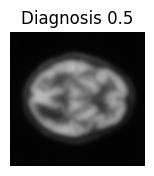

Epoch 323: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0016, 


Epoch 323, Training Loss: 0.014341903326567262, Validation Loss: 0.0013275353121571243


Epoch 324: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 324, Training Loss: 0.011559115431737155, Validation Loss: 0.001962551788892597


Epoch 325: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0027, 


Epoch 325, Training Loss: 0.014205244311597198, Validation Loss: 0.003072223160415888


Epoch 326: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0017, 


Epoch 326, Training Loss: 0.03198783681727946, Validation Loss: 0.003358774818480015


Epoch 327: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0012, 


Epoch 327, Training Loss: 0.02058404980925843, Validation Loss: 0.0029893971513956785


Epoch 328: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0030, 


Epoch 328, Training Loss: 0.017262315552216023, Validation Loss: 0.0017045631539076567


Epoch 329: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0028, 


Epoch 329, Training Loss: 0.018016983987763524, Validation Loss: 0.003606950049288571


Epoch 330: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 330, Training Loss: 0.027113243588246405, Validation Loss: 0.0025091986171901226


Epoch 331: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0040, 


Epoch 331, Training Loss: 0.02119219012092799, Validation Loss: 0.0013176460633985698


Epoch 332: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0013, 


Epoch 332, Training Loss: 0.016897081397473812, Validation Loss: 0.0015159169561229646


Epoch 333: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0027, 


Epoch 333, Training Loss: 0.011148821678943932, Validation Loss: 0.0018101985333487391


Epoch 334: 100%|█| 16/16 [00:10<00:00,  1.52it/s, loss=tensor(0.0015, 


Epoch 334, Training Loss: 0.016432768577942625, Validation Loss: 0.0016730965580791235


Epoch 335: 100%|█| 16/16 [00:10<00:00,  1.55it/s, loss=tensor(0.0012, 


Epoch 335, Training Loss: 0.011220302432775497, Validation Loss: 0.001213921350426972


Epoch 336: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 336, Training Loss: 0.01888036838499829, Validation Loss: 0.0035756893921643496


Epoch 337: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 337, Training Loss: 0.01554661663249135, Validation Loss: 0.001525091181974858


Epoch 338: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0017, 


Epoch 338, Training Loss: 0.0184604826499708, Validation Loss: 0.0013622206752188504


Epoch 339: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0025, 


Epoch 339, Training Loss: 0.021317418257240206, Validation Loss: 0.0018973087426275015


Epoch 340: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0027, 


Epoch 340, Training Loss: 0.016002629534341395, Validation Loss: 0.0035443385131657124


Epoch 341: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0015, 


Epoch 341, Training Loss: 0.0154069890268147, Validation Loss: 0.0025368976639583707


Epoch 342: 100%|█| 16/16 [00:10<00:00,  1.55it/s, loss=tensor(0.0013, 


Epoch 342, Training Loss: 0.013918641314376146, Validation Loss: 0.0012901097070425749


Epoch 343: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0015, 


Epoch 343, Training Loss: 0.01626133534591645, Validation Loss: 0.003035175148397684


Epoch 344: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 344, Training Loss: 0.014564457582309842, Validation Loss: 0.001563813362736255


Epoch 345: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 345, Training Loss: 0.009970880288165063, Validation Loss: 0.0022759472485631704


Epoch 346: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 346, Training Loss: 0.009896573785226792, Validation Loss: 0.001286584185436368


Epoch 347: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0020, 


Epoch 347, Training Loss: 0.011253289820160717, Validation Loss: 0.0012483503087423742


Epoch 348: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 348, Training Loss: 0.013141563162207603, Validation Loss: 0.0018293014145456254


Epoch 349: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 349, Training Loss: 0.0132913967827335, Validation Loss: 0.0017000826192088425


Epoch 350: 100%|█| 16/16 [00:09<00:00,  1.66it/s, loss=tensor(0.0041, 


Epoch 350, Training Loss: 0.014410210540518165, Validation Loss: 0.0015621960046701133


Epoch 351: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 351, Training Loss: 0.026228017813991755, Validation Loss: 0.0015302383108064532


Epoch 352: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0024, 


Epoch 352, Training Loss: 0.021355292876251042, Validation Loss: 0.0015714672626927495


Epoch 353: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 353, Training Loss: 0.015540378692094237, Validation Loss: 0.0014803546364419162


Epoch 354: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 354, Training Loss: 0.01341611286625266, Validation Loss: 0.0021860491251572967


Epoch 355: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0010, 


Epoch 355, Training Loss: 0.011355035123415291, Validation Loss: 0.0013936619507148862


Epoch 356: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0033, 


Epoch 356, Training Loss: 0.019466805271804333, Validation Loss: 0.0012095565325580537


Epoch 357: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0049, 


Epoch 357, Training Loss: 0.02046245220117271, Validation Loss: 0.0011649272637441754


Epoch 358: 100%|█| 16/16 [00:09<00:00,  1.66it/s, loss=tensor(0.0016, 


Epoch 358, Training Loss: 0.015337831748183817, Validation Loss: 0.0014506932348012924


Epoch 359: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0014, 


Epoch 359, Training Loss: 0.012292419211007655, Validation Loss: 0.0014056150102987885


Epoch 360: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0010, 


Epoch 360, Training Loss: 0.011374802037607878, Validation Loss: 0.0011769402772188187


Epoch 361: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 361, Training Loss: 0.01233474415494129, Validation Loss: 0.0016348875360563397


Epoch 362: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0011, 


Epoch 362, Training Loss: 0.011934061592910439, Validation Loss: 0.0016360158333554864


Epoch 363: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0018, 


Epoch 363, Training Loss: 0.013653331669047475, Validation Loss: 0.0011759281624108553


Epoch 364: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0060, 


Epoch 364, Training Loss: 0.014076304854825139, Validation Loss: 0.002387601067312062


Epoch 365: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0040, 


Epoch 365, Training Loss: 0.025529982580337673, Validation Loss: 0.0029923401307314634


Epoch 366: 100%|█| 16/16 [00:09<00:00,  1.66it/s, loss=tensor(0.0029, 


Epoch 366, Training Loss: 0.03053093299968168, Validation Loss: 0.0027308851713314652


Epoch 367: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0016, 


Epoch 367, Training Loss: 0.022247379180043936, Validation Loss: 0.0026926285354420543


Epoch 368: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0021, 


Epoch 368, Training Loss: 0.018175280187278986, Validation Loss: 0.002125071478076279


Epoch 369: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0039, 


Epoch 369, Training Loss: 0.025501825322862715, Validation Loss: 0.0013429540558718145


Epoch 370: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 370, Training Loss: 0.01797745074145496, Validation Loss: 0.003627472324296832


Epoch 371: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0009, 


Epoch 371, Training Loss: 0.01250249837175943, Validation Loss: 0.0014901840477250516


Epoch 372: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0009, 


Epoch 372, Training Loss: 0.012043002061545849, Validation Loss: 0.0013975538313388824


Epoch 373: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 373, Training Loss: 0.010599624132737517, Validation Loss: 0.0012765871360898018


Epoch 374: 100%|█| 16/16 [00:09<00:00,  1.65it/s, loss=tensor(0.0013, 


Epoch 374, Training Loss: 0.0113088617217727, Validation Loss: 0.0011584303574636579


Epoch 375: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0022, 


Epoch 375, Training Loss: 0.015523247013334185, Validation Loss: 0.0020202146843075752


Epoch 376: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 376, Training Loss: 0.01699115859810263, Validation Loss: 0.002533384133130312


Epoch 377: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 377, Training Loss: 0.013160807255189866, Validation Loss: 0.001585477846674621


Epoch 378: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0016, 


Epoch 378, Training Loss: 0.010680505482014269, Validation Loss: 0.0010625445283949375


Epoch 379: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 379, Training Loss: 0.011599688441492617, Validation Loss: 0.001775394193828106


Epoch 380: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0009, 


Epoch 380, Training Loss: 0.009624630416510627, Validation Loss: 0.0014353871229104698


Epoch 381: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 381, Training Loss: 0.009716667758766562, Validation Loss: 0.0011997674009762704


Epoch 382: 100%|█| 16/16 [00:09<00:00,  1.64it/s, loss=tensor(0.0008, 


Epoch 382, Training Loss: 0.009119181981077418, Validation Loss: 0.0011552153155207634


Epoch 383: 100%|█| 16/16 [00:11<00:00,  1.45it/s, loss=tensor(0.0010, 


Epoch 383, Training Loss: 0.00892135631875135, Validation Loss: 0.0011987523175776005


Epoch 384: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0009, 


Epoch 384, Training Loss: 0.008717406279174611, Validation Loss: 0.0009797288221307099


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.39it/s]


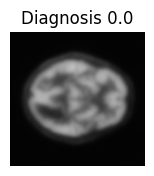

Epoch 385: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0026, 


Epoch 385, Training Loss: 0.010415697674034163, Validation Loss: 0.0017297902959398925


Epoch 386: 100%|█| 16/16 [00:09<00:00,  1.64it/s, loss=tensor(0.0023, 


Epoch 386, Training Loss: 0.025703618419356644, Validation Loss: 0.005870111985132098


Epoch 387: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0070, 


Epoch 387, Training Loss: 0.05863067286554724, Validation Loss: 0.007827532244846225


Epoch 388: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0034, 


Epoch 388, Training Loss: 0.04164554877206683, Validation Loss: 0.0030880022095516324


Epoch 389: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 389, Training Loss: 0.021365003776736557, Validation Loss: 0.0015555854188278317


Epoch 390: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0016, 


Epoch 390, Training Loss: 0.013999140355736017, Validation Loss: 0.001847644743975252


Epoch 391: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 391, Training Loss: 0.012336554616922513, Validation Loss: 0.001207697088830173


Epoch 392: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 392, Training Loss: 0.010466836101841182, Validation Loss: 0.0016611384926363826


Epoch 393: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0010, 


Epoch 393, Training Loss: 0.009182025940390304, Validation Loss: 0.0011054903152398765


Epoch 394: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0012, 


Epoch 394, Training Loss: 0.011224243207834661, Validation Loss: 0.0010518427297938615


Epoch 395: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 395, Training Loss: 0.010312257683835924, Validation Loss: 0.0010377212893217802


Epoch 396: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0017, 


Epoch 396, Training Loss: 0.013711492589209229, Validation Loss: 0.002201800001785159


Epoch 397: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0022, 


Epoch 397, Training Loss: 0.025802002113778144, Validation Loss: 0.0036596058635041118


Epoch 398: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0026, 


Epoch 398, Training Loss: 0.023290726414415985, Validation Loss: 0.0021791363833472133


Epoch 399: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 399, Training Loss: 0.017232836922630668, Validation Loss: 0.0012568997335620224


Epoch 400: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0017, 


Epoch 400, Training Loss: 0.019390221685171127, Validation Loss: 0.0013017667224630713


Epoch 401: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0019, 


Epoch 401, Training Loss: 0.013524232315830886, Validation Loss: 0.004499290720559657


Epoch 402: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0032, 


Epoch 402, Training Loss: 0.03774977556895465, Validation Loss: 0.0034748620819300413


Epoch 403: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 403, Training Loss: 0.023219263937789947, Validation Loss: 0.0016711368225514889


Epoch 404: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 404, Training Loss: 0.013117115013301373, Validation Loss: 0.0013718926347792149


Epoch 405: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 405, Training Loss: 0.00968548416858539, Validation Loss: 0.0010597754153423011


Epoch 406: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0013, 


Epoch 406, Training Loss: 0.009999999223509803, Validation Loss: 0.0012508818181231618


Epoch 407: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0014, 


Epoch 407, Training Loss: 0.009402228082763031, Validation Loss: 0.0010671387426555157


Epoch 408: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0019, 


Epoch 408, Training Loss: 0.012896866508526728, Validation Loss: 0.003008614992722869


Epoch 409: 100%|█| 16/16 [00:10<00:00,  1.50it/s, loss=tensor(0.0015, 


Epoch 409, Training Loss: 0.013606618158519268, Validation Loss: 0.0018270749133080244


Epoch 410: 100%|█| 16/16 [00:10<00:00,  1.53it/s, loss=tensor(0.0013, 


Epoch 410, Training Loss: 0.011226348753552884, Validation Loss: 0.0011810779105871916


Epoch 411: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0010, 


Epoch 411, Training Loss: 0.008953235519584268, Validation Loss: 0.0014699686435051262


Epoch 412: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0009, 


Epoch 412, Training Loss: 0.007568861357867718, Validation Loss: 0.0009430178324691951


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.92it/s]


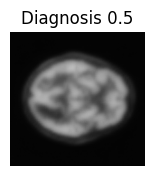

Epoch 413: 100%|█| 16/16 [00:10<00:00,  1.50it/s, loss=tensor(0.0009, 


Epoch 413, Training Loss: 0.007847640110412613, Validation Loss: 0.0009653178858570755


Epoch 414: 100%|█| 16/16 [00:09<00:00,  1.65it/s, loss=tensor(0.0009, 


Epoch 414, Training Loss: 0.00889981648651883, Validation Loss: 0.0010906382813118398


Epoch 415: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0009, 


Epoch 415, Training Loss: 0.008964248845586553, Validation Loss: 0.0009137479937635362


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.35it/s]


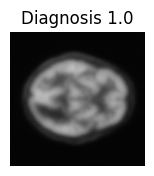

Epoch 416: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0012, 


Epoch 416, Training Loss: 0.013020614045672119, Validation Loss: 0.002298849984072149


Epoch 417: 100%|█| 16/16 [00:10<00:00,  1.49it/s, loss=tensor(0.0026, 


Epoch 417, Training Loss: 0.019285125308670104, Validation Loss: 0.002961132558993995


Epoch 418: 100%|█| 16/16 [00:09<00:00,  1.63it/s, loss=tensor(0.0011, 


Epoch 418, Training Loss: 0.015195382351521403, Validation Loss: 0.0015679336502216756


Epoch 419: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0014, 


Epoch 419, Training Loss: 0.014882924791891128, Validation Loss: 0.003028040169738233


Epoch 420: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0033, 


Epoch 420, Training Loss: 0.014956292463466525, Validation Loss: 0.001601794094312936


Epoch 421: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0045, 


Epoch 421, Training Loss: 0.0263363603153266, Validation Loss: 0.0016110735014081001


Epoch 422: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0085, 


Epoch 422, Training Loss: 0.042679678939748555, Validation Loss: 0.0019367416971363127


Epoch 423: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0032, 


Epoch 423, Training Loss: 0.02711346506839618, Validation Loss: 0.0021334700868465006


Epoch 424: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0036, 


Epoch 424, Training Loss: 0.01476513798115775, Validation Loss: 0.0013590004527941346


Epoch 425: 100%|█| 16/16 [00:10<00:00,  1.50it/s, loss=tensor(0.0014, 


Epoch 425, Training Loss: 0.012696503952611238, Validation Loss: 0.0010469832341186702


Epoch 426: 100%|█| 16/16 [00:09<00:00,  1.62it/s, loss=tensor(0.0022, 


Epoch 426, Training Loss: 0.011755495594115928, Validation Loss: 0.001517134835012257


Epoch 427: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 427, Training Loss: 0.011334710870869458, Validation Loss: 0.0010775696719065309


Epoch 428: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 428, Training Loss: 0.009869156288914382, Validation Loss: 0.001304310280829668


Epoch 429: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0017, 


Epoch 429, Training Loss: 0.008956676203524694, Validation Loss: 0.0013255635858513415


Epoch 430: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0012, 


Epoch 430, Training Loss: 0.008606258343206719, Validation Loss: 0.00114089110866189


Epoch 431: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0013, 


Epoch 431, Training Loss: 0.00991776050068438, Validation Loss: 0.0013910825364291668


Epoch 432: 100%|█| 16/16 [00:10<00:00,  1.48it/s, loss=tensor(0.0011, 


Epoch 432, Training Loss: 0.008628753945231438, Validation Loss: 0.0008897763327695429


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.63it/s]


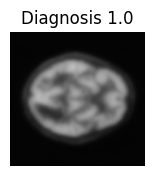

Epoch 433: 100%|█| 16/16 [00:10<00:00,  1.47it/s, loss=tensor(0.0014, 


Epoch 433, Training Loss: 0.008441462996415794, Validation Loss: 0.0017465280834585428


Epoch 434:  12%|▏| 2/16 [00:01<00:13,  1.05it/s, loss=tensor(0.0011, d


KeyboardInterrupt: 

In [26]:
import time
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()

vAE_model.eval()
LDM_model.to(device)
vAE_model.to(device)

best_val = 1e3

for epoch in range(training_epochs):



    LDM_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images, diag = batch
        diag = diag.unsqueeze(dim=1)
        diag = diag.unsqueeze(dim=1).float().to(device)
        optimiser.zero_grad(set_to_none=True)

        with torch.no_grad():
          z_mean, z_std = vAE_model.encode(images.float().unsqueeze(dim=1).to(device))

        padded_z_mean = F.pad(z_mean, (2, 2, 2, 2))  # pad 4 pixels on right and bottom

        padded_z_mean = padded_z_mean.to(device)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(padded_z_mean).to(device)
            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long().to(device)

            # Get model prediction
            noise_pred = inferer(inputs=padded_z_mean, diffusion_model=LDM_model, noise=noise, timesteps=timesteps, mode="crossattn", condition=diag)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimiser)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": loss})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        LDM_model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(valid_loader):
          images, diag = batch
          diag = diag.unsqueeze(dim=1)
          diag = diag.unsqueeze(dim=1).float().to(device)
          optimiser.zero_grad(set_to_none=True)

          with torch.no_grad():
            z_mean, z_std = vAE_model.encode(images.float().unsqueeze(dim=1).to(device))

            padded_z_mean = F.pad(z_mean, (2, 2, 2, 2))  # pad 4 pixels on right and bottom

            padded_z_mean = padded_z_mean.to(device)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(padded_z_mean).to(device)
                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long().to(device)

                # Get model prediction
                noise_pred = inferer(inputs=padded_z_mean, diffusion_model=LDM_model, noise=noise, timesteps=timesteps, mode="crossattn", condition=diag)

                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        print(f"Epoch {epoch}, Training Loss: {epoch_loss / (step + 1)}, Validation Loss: {val_epoch_loss / (step + 1)}")

        if val_epoch_loss / (step + 1) < best_val:
          best_val = val_epoch_loss / (step + 1)
          torch.save(LDM_model.state_dict(), os.path.join('Checkpoints_conditioned', f"trained_LDM_epoch_{epoch}.pt"))

          # Sampling image during training
          noise = torch.randn((1, 1, 64, 64))
          noise = noise.to(device)
          ldm_scheduler.set_timesteps(num_inference_steps=1000)
          with autocast(enabled=True):
              list_diag = [torch.tensor(0.0), torch.tensor(0.5), torch.tensor(1.0)]
              diagnosis = random.choice(list_diag)
              diag = diagnosis.unsqueeze(dim=-1)
              diag = diag.unsqueeze(dim=-1)
              diag = diag.unsqueeze(dim=-1).to(device)
              image = inferer.sample(input_noise=noise, diffusion_model=LDM_model, scheduler=ldm_scheduler, mode="crossattn", conditioning=diag)
              image = image[:, :, 2:-2, 2:-2]
              image = vAE_model.decode(image).cpu().detach().numpy()

          plt.figure(figsize=(2, 2))
          plt.imshow(image[0, 0], vmin=0, vmax=1, cmap="gray")
          plt.tight_layout()
          plt.title(f"Diagnosis {diagnosis}")
          plt.axis("off")
          plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")